In [8]:
import importlib
from jax.scipy.linalg import inv, det, svd
import jax.numpy as jnp
from jax import random, jit, lax
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import jax
from jax_models import visualize_observations, KuramotoSivashinsky, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps
from jax.tree_util import Partial

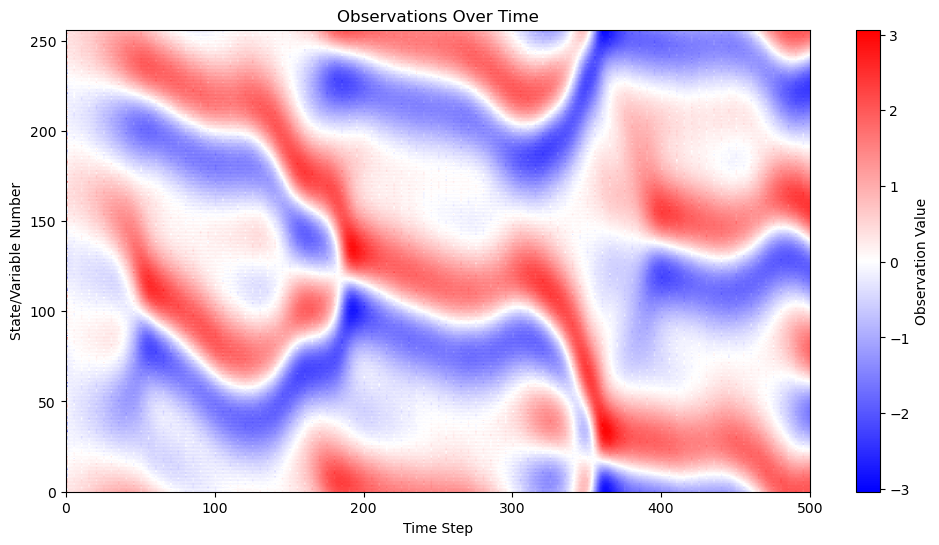

In [2]:
# Initialize parameters
num_steps = 500  # Number of simulation steps
n = 256 # Dimensionality of the state space for KS model
observation_interval = 5  # Interval at which observations are made
dt = 0.25  # Time step for the KS model

ks_model = KuramotoSivashinsky(dt=dt, s=n, l=22, M=16)

# Initial state
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.01 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)
# Generate observations
ks_step = Partial(ks_model.step)
observations, true_states = generate_true_states(key, num_steps, n, x0, H, Q, R, ks_step, observation_interval)

# Visualize the observations
visualize_observations(true_states)

In [3]:
n_ensemble = 10
local_mat = generate_gc_localization_matrix(n, 2)
inflation = 1.0


In [5]:

radii = [2,5]
inflations = [1.0]
num_trials = 2
ensemble_sizes = [10]


In [10]:
from concurrent.futures import ProcessPoolExecutor
import jax.numpy as jnp


def run_trial(trial_key, radii, inflations, ensemble_sizes, num_steps, observation_interval, n, H, Q, R, ks_step, initial_state):
    observations, true_states = generate_true_states(trial_key, num_steps, n, initial_state, H, Q, R, ks_step, observation_interval)
    observed_true_states = true_states[observation_times]
    trial_errors = {}
    trial_std_errors = {}
    for radius in radii:
        local_mat = generate_gc_localization_matrix(n, radius)
        for inflation in inflations:
            for n_ensemble in ensemble_sizes:
                print("aiya")
                # key, run_key = random.split(key)
                # ensemble_init = random.multivariate_normal(run_key, initial_state, Q, (n_ensemble,)).T
                # states, covariances = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation, run_key)
                # average_state = jnp.mean(states, axis=2)
                # observed_average_state = average_state[observation_times]
                # error = jnp.sqrt(jnp.mean((observed_average_state - observed_true_states) ** 2, axis=1))
                trial_errors[(radius, inflation, n_ensemble)] = error
                observed_states = states[observation_times, :, :]
                std_dev = jnp.mean(jnp.std(observed_states, axis = 2), axis = 1)
                trial_std_errors[(radius, inflation, n_ensemble)] = std_dev
    return trial_errors, trial_std_errors

# Preparation for parallel execution
observation_times = jnp.arange(0, num_steps, observation_interval)
initial_state = random.normal(random.PRNGKey(0), (n,))

# Execute trials in parallel
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(run_trial, random.PRNGKey(trial), radii, inflations, ensemble_sizes, num_steps, observation_interval, n, H, Q, R, ks_step, initial_state) for trial in range(num_trials)]
    results = [f.result() for f in futures]

# Processing results (aggregating errors and std_errors from all trials)
errors = {}
std_errors = {}
for trial_errors, trial_std_errors in results:
    for key in trial_errors:
        if key not in errors:
            errors[key] = []
            std_errors[key] = []
        errors[key].append(trial_errors[key])
        std_errors[key].append(trial_std_errors[key])


Process ForkProcess-35:
Process ForkProcess-57:
Process ForkProcess-61:
Process ForkProcess-58:
Process ForkProcess-54:
Process ForkProcess-53:
Process ForkProcess-48:
Process ForkProcess-52:
Process ForkProcess-47:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-63:
Process ForkProcess-46:
Process ForkProcess-40:
Process ForkProcess-55:
Process ForkProcess-50:
Process ForkProcess-60:
Process ForkProcess-38:
Process ForkProcess-42:
Process ForkProcess-64:
Process ForkProcess-49:
Process ForkProcess-56:
  File "/home/eluk/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkProcess-45:
Traceback (most recent call last):
Process ForkProcess-39:
Process ForkProcess-36:
Process ForkProcess-59:
Process ForkProcess-51:
Process ForkProcess-44:
Traceback (most recent call last):
Process ForkProcess-41:
Traceback (most recent call last):
Traceback (most recent call la

KeyboardInterrupt: 

In [ ]:
import pickle
import os
from datetime import datetime
from tqdm import tqdm

# radii = [2,5, 10,25, 50, 100]
# inflations = [1.0, 1.05, 1.1, 1.2, 1.3, 1.5]
# num_trials = 10
# ensemble_sizes = [5, 10,20, 30,40]
num_steps = 1000

observation_times = jnp.arange(0, num_steps, observation_interval)

key = random.PRNGKey(0)

initial_state = random.normal(key, (n,))

std_errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

for trial in tqdm(range(num_trials), desc="Running Trials"):
    key, trial_key = random.split(key) 
    print(f"Trial {trial}")
    observations, true_states = generate_true_states(trial_key, num_steps, n, initial_state, H, Q, R, ks_step, observation_interval)
    observed_true_states = true_states[observation_times] #only comparing metrics for analysis steps
    for radius in radii:
        local_mat = generate_gc_localization_matrix(n, radius)
        for inflation in inflations:
            for n_ensemble in ensemble_sizes:
                key, run_key = random.split(key)  
                ensemble_init = random.multivariate_normal(run_key, initial_state, Q, (n_ensemble,)).T
                states, covariances = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation, run_key)
                # expected shape (n_timesteps, state_dimension, n_ensemble)
                average_state = jnp.mean(states, axis=2)  # Calculate the mean along the ensemble dimension
                observed_average_state = average_state[observation_times] # only comparing metrics for analysis steps
                error = jnp.sqrt(jnp.mean((observed_average_state - observed_true_states) ** 2, axis=1))
                errors[(radius, inflation, n_ensemble)].append(error)
                observed_states = states[observation_times, :, :]
                std_dev = jnp.mean(jnp.std(observed_states, axis = 2), axis = 1)  # Standard deviation across all ensemble members and state dimensions at observation times
                std_errors[(radius, inflation, n_ensemble)].append(std_dev)

# Preparing data for saving
all_data = {
    'std_errors': std_errors,
    'errors': errors,
    'parameters': {
        'radii': radii,
        'inflations': inflations,
        'ensemble_sizes': ensemble_sizes,
        'num_trials': num_trials,
        'filter_params': (H,Q,R, observation_interval, num_steps)
    }
}

# File saving path
directory = '/central/home/eluk/variational_filtering/experiment_data/'
filename = f'ks_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
file_path = os.path.join(directory, filename)

with open(file_path, 'wb') as f:

    pickle.dump(all_data, f)

Running Trials:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Trial 0


Running Trials:  10%|██████▌                                                          | 1/10 [08:55<1:20:18, 535.37s/it]

Trial 1


Running Trials:  20%|█████████████                                                    | 2/10 [17:46<1:11:01, 532.72s/it]

Trial 2


Running Trials:  30%|███████████████████▌                                             | 3/10 [26:36<1:02:00, 531.55s/it]

Trial 3


Running Trials:  40%|██████████████████████████▊                                        | 4/10 [35:27<53:09, 531.52s/it]

Trial 4


Running Trials:  50%|█████████████████████████████████▌                                 | 5/10 [44:17<44:14, 530.99s/it]

Trial 5


Running Trials:  60%|████████████████████████████████████████▏                          | 6/10 [53:05<35:19, 529.99s/it]

Trial 6


Running Trials:  70%|█████████████████████████████████████████████▌                   | 7/10 [1:02:00<26:34, 531.39s/it]

Trial 7


Running Trials:  80%|████████████████████████████████████████████████████             | 8/10 [1:15:16<20:31, 615.80s/it]

Trial 8


In [ ]:
%env XLA_FLAGS=--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32

num_devices = jax.local_device_count()
print(f"Running on {num_devices} devices")
print(jax.devices())

In [8]:
num_cpus = os.cpu_count()
print(f"Number of CPUs available: {num_cpus}")

Number of CPUs available: 32


In [53]:
#!lscpu

In [13]:
states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)


In [1]:
states

NameError: name 'states' is not defined

In [ ]:
# File saving path
directory = '/central/home/eluk/variational_filtering/experiment_data/'
filename = f'ks_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
file_path = os.path.join(directory, filename)

with open(file_path, 'wb') as f:
    pickle.dump(all_data, f)

: 

In [2]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

numbers = [20, 21, 22, 23, 24, 25]  # Numbers to calculate factorial for

# Serial execution
serial_results = []
for number in numbers:
    result = factorial(number)
    serial_results.append(result)
    print(f"Factorial of {number} is {result}")


Factorial of 20 is 2432902008176640000
Factorial of 21 is 51090942171709440000
Factorial of 22 is 1124000727777607680000
Factorial of 23 is 25852016738884976640000
Factorial of 24 is 620448401733239439360000
Factorial of 25 is 15511210043330985984000000


In [9]:
from multiprocessing import Pool

def parallel_factorial(number):
    result = factorial(number)
    print(f"Factorial of {number} is {result}")  # Note: Printing from workers might not appear in order
    return result

if __name__ == "__main__":
    with Pool(processes=4) as pool:  # Adjust 'processes' based on your machine's CPU cores
        parallel_results = pool.map(parallel_factorial, numbers)


Factorial of 22 is 1124000727777607680000Factorial of 21 is 51090942171709440000Factorial of 20 is 2432902008176640000Factorial of 23 is 25852016738884976640000




Factorial of 24 is 620448401733239439360000Factorial of 25 is 15511210043330985984000000


In [59]:
from tqdm import tqdm

if __name__ == "__main__":
    with Pool(processes=4) as pool:
        results = list(tqdm(pool.imap_unordered(parallel_factorial, numbers), total=len(numbers)))


Factorial of 23 is 25852016738884976640000Factorial of 22 is 1124000727777607680000Factorial of 20 is 2432902008176640000

  0%|                                                                                             | 0/6 [00:00<?, ?it/s]


Factorial of 21 is 51090942171709440000
Factorial of 24 is 620448401733239439360000Factorial of 25 is 15511210043330985984000000





100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1100.87it/s]
